# Go/No-Go Task Minimal Preprocessing Pipeline

This notebook demonstrates how to use the minimal preprocessing pipeline for Go/No-Go task data. The minimal pipeline includes basic preprocessing steps that are essential for further analysis without more complex operations like ICA.

## Pipeline Overview

The minimal preprocessing pipeline includes the following steps:
1. **Load Data**: Load raw EEG data files
2. **Channel Preparation**: Configure channel types and handle missing montage positions
3. **Filtering**: Apply bandpass and notch filters to remove noise
4. **Epoching**: Segment the continuous data into epochs around stimulus events
5. **Save Checkpoint**: Save the preprocessed data for further analysis

## Setting Up the Environment

First, let's import the necessary libraries and configure the environment.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import mne
import yaml
from pathlib import Path
import logging
import importlib

# Add the parent directory to path to import custom modules
sys.path.append(os.path.abspath('../..'))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('gonogo_minimal_preprocessing')

# MNE settings
mne.set_log_level('INFO')
%matplotlib inline

## Loading the Pipeline Configuration

We'll load the minimal pipeline configuration from the YAML file.

In [2]:
# Load the minimal pipeline configuration
config_path = '../../configs/gonogo_minimal_pipeline.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration from {config_path}")

print("Pipeline steps:")
for step in config['pipeline']['steps']:
    print(f"- {step['name']}")

# Extract key configuration parameters
root_dir = config['directory']['root']
raw_data_dir = os.path.join(root_dir, config['directory']['raw_data_dir'])
processed_dir = os.path.join(root_dir, config['directory']['processed_dir'])
file_pattern = config['file_path_pattern']

# Ensure directories exist
os.makedirs(processed_dir, exist_ok=True)

Loaded configuration from ../../configs/gonogo_minimal_pipeline.yml
Pipeline steps:
- LoadData
- PrepChannelsStep
- FilterStep
- EpochingStep
- SaveCheckpoint


## Step 1: Loading the Data

The first step is to load the raw EEG data. For Go/No-Go tasks, we expect the data to be in FIFF format.

In [3]:
# Step 1: Loading the Data
# Extract loading parameters from the configuration
load_data_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'LoadData')

# Construct the file path
file_path = os.path.join(raw_data_dir, file_pattern)

# Import and use the LoadData class from the pipeline
from scr.steps.load import LoadData

# Create and apply the load data step
logger.info(f"Loading data using LoadData")
load_data_step = LoadData(params=load_data_config.get('params', {}))

# For LoadData step, we pass the file path in the params
load_params = load_data_step.params.copy()
load_params["input_file"] = file_path
load_data_step.params = load_params

raw = load_data_step.run(None)

# Display basic information about the raw data
print("\nRaw data information:")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")

# Plot the raw data (first 10 seconds)
raw.plot(duration=10, n_channels=20, title='Raw EEG data')

2025-04-14 16:17:06,610 - root - INFO - [ICAExtractionStep] Qt version: 5.15.2
2025-04-14 16:17:06,872 - numexpr.utils - INFO - NumExpr defaulting to 12 threads.
2025-04-14 16:17:07,280 - root - INFO - [__init__.py] All step classes have been registered in STEP_REGISTRY.
2025-04-14 16:17:07,281 - gonogo_minimal_preprocessing - INFO - Loading data using LoadData


Opening raw data file D:\Yann\neurotheque_resources\data\pilot_data\tasks\sub-01_ses-001_task-gng_image_run-01_raw.fif...
Isotrak not found
    Range : 81028 ... 385484 =    270.093 ...  1284.947 secs
Ready.
Reading 0 ... 304456  =      0.000 ...  1014.853 secs...

Raw data information:
Number of channels: 27
Sampling frequency: 300.0 Hz
Duration: 1014.85 seconds
Using qt as 2D backend.


## Pre-Processing: Handle ECG and Non-EEG Channels

Before the main channel preparation, we'll explicitly check for and handle the ECG and non-EEG channels.

In [4]:
# Print channel names before prep
print("\nChannel names before preparation:")
print(raw.ch_names)

# Check for channels with different formats to identify the ECG
print("\nSearching for potential ECG channels...")
for ch in raw.ch_names:
    if 'X1:ECG' in ch:
        print(f"Found X1:ECG channel: {ch}")

# The specific ECG channel name is 'EEG X1:ECG-Pz'
ecg_channel = 'EEG X1:ECG-Pz'
if ecg_channel in raw.ch_names:
    logger.info(f"Dropping ECG channel: {ecg_channel}")
    raw.drop_channels([ecg_channel])

# Also check for any other non-EEG channels that might need manual dropping
non_eeg_channel_patterns = ['EEG X2:-Pz', 'EEG X3:-Pz', 'CM', 'EEG A1-Pz', 'EEG A2-Pz', 'Event']
non_eeg_chs = [ch for ch in raw.ch_names if ch in non_eeg_channel_patterns]

if non_eeg_chs:
    logger.info(f"Manually dropping additional non-EEG channels: {non_eeg_chs}")
    raw.drop_channels(non_eeg_chs)

2025-04-14 16:17:10,346 - gonogo_minimal_preprocessing - INFO - Dropping ECG channel: EEG X1:ECG-Pz
2025-04-14 16:17:10,365 - gonogo_minimal_preprocessing - INFO - Manually dropping additional non-EEG channels: ['CM', 'EEG A1-Pz', 'EEG X3:-Pz', 'EEG X2:-Pz', 'EEG A2-Pz', 'Event']



Channel names before preparation:
['EEG P3-Pz', 'EEG C3-Pz', 'EEG F3-Pz', 'EEG Fz-Pz', 'EEG F4-Pz', 'EEG C4-Pz', 'EEG P4-Pz', 'EEG Cz-Pz', 'CM', 'EEG A1-Pz', 'EEG Fp1-Pz', 'EEG Fp2-Pz', 'EEG T3-Pz', 'EEG T5-Pz', 'EEG O1-Pz', 'EEG O2-Pz', 'EEG X3:-Pz', 'EEG X2:-Pz', 'EEG F7-Pz', 'EEG F8-Pz', 'EEG X1:ECG-Pz', 'EEG A2-Pz', 'EEG T6-Pz', 'EEG T4-Pz', 'Pz', 'Trigger', 'Event']

Searching for potential ECG channels...
Found X1:ECG channel: EEG X1:ECG-Pz


## Step 2: Channel Preparation

The `PrepChannelsStep` handles channel renaming, type setting, and montage application.

In [5]:
# Step 2: Channel Preparation
# Extract parameters from the configuration
prep_channels_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'PrepChannelsStep')

# Set the referencing parameters
if 'params' not in prep_channels_config:
    prep_channels_config['params'] = {}
    
prep_channels_config['params']['reference'] = {
    'method': 'average',  # Change from Pz (channels) to average reference
    'projection': False
}

# Force reload the module to ensure we have the latest version
import scr.steps.prepchannels
importlib.reload(scr.steps.prepchannels)

# Use the PrepChannelsStep with referencing
from scr.steps.prepchannels import PrepChannelsStep

# Create and apply the channel preparation step
logger.info(f"Preparing channels with referencing")
prep_channels_step = PrepChannelsStep(params=prep_channels_config['params'])
raw = prep_channels_step.run(raw)

# Print channel names after prep to verify ECG channel was dropped
print("\nChannel names after preparation:")
print(raw.ch_names)

2025-04-14 16:17:12,579 - gonogo_minimal_preprocessing - INFO - Preparing channels with referencing
2025-04-14 16:17:12,580 - root - INFO - [PrepChannelsStep] Running with params: {'on_missing': 'ignore', 'reference': {'method': 'average', 'projection': False}}
2025-04-14 16:17:12,580 - root - INFO - No non-EEG channels found to drop
2025-04-14 16:17:12,583 - root - INFO - Renamed 18 EEG channels
d:\Yann\neurotheque_resources\scr\steps\prepchannels.py:53: RuntimeWarning: The unit for channel(s) Trigger has changed from NA to V.
  data.set_channel_types({ch: 'stim'})
2025-04-14 16:17:12,585 - root - INFO - Channel types set: 19 EEG, 1 STIM, 0 MISC
2025-04-14 16:17:12,585 - root - INFO - [PrepChannelsStep] Applying re-referencing with params: {'method': 'average', 'projection': False}
2025-04-14 16:17:12,586 - root - INFO - [apply_reference] Re-referencing method=average, projection=False
2025-04-14 16:17:12,587 - root - INFO - [apply_reference] Using average reference for EEG channels.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


2025-04-14 16:17:12,633 - root - INFO - [apply_reference] Re-reference complete.
2025-04-14 16:17:12,634 - root - INFO - [PrepChannelsStep] Re-referencing applied successfully
2025-04-14 16:17:12,642 - root - INFO - [PrepChannelsStep] Standard 10-20 montage applied
2025-04-14 16:17:12,643 - root - INFO - [PrepChannelsStep] Channels prepared successfully.



Channel names after preparation:
['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'T6', 'T4', 'Pz', 'Trigger']


## Step 3: Filtering

Filtering is a crucial step to remove unwanted frequency components from the signal. We apply:
1. A bandpass filter to remove slow drifts and high-frequency noise
2. Notch filters to remove power line interference

2025-04-14 16:17:15,301 - gonogo_minimal_preprocessing - INFO - Applying filtering using FilterStep


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Effective window size : 6.827 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Plotting power spectral density (dB=True).


c:\Users\s\anaconda3\envs\eeg_analysis\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


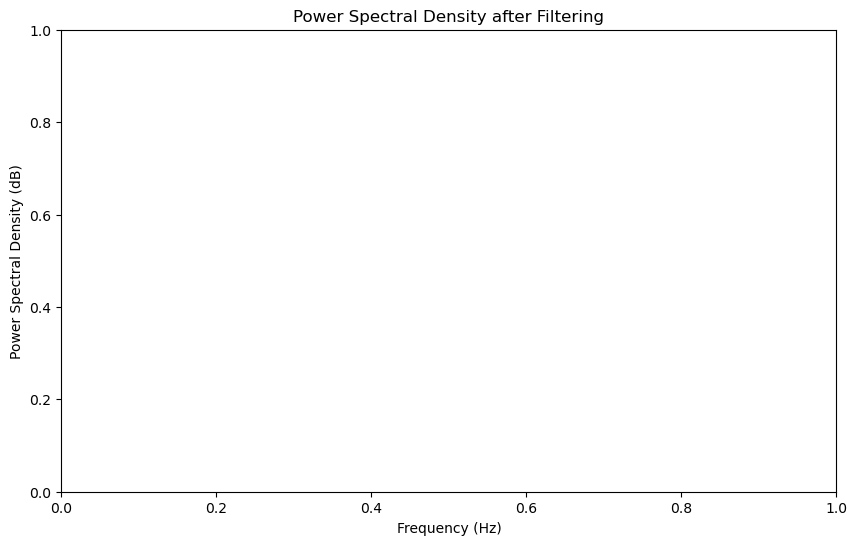

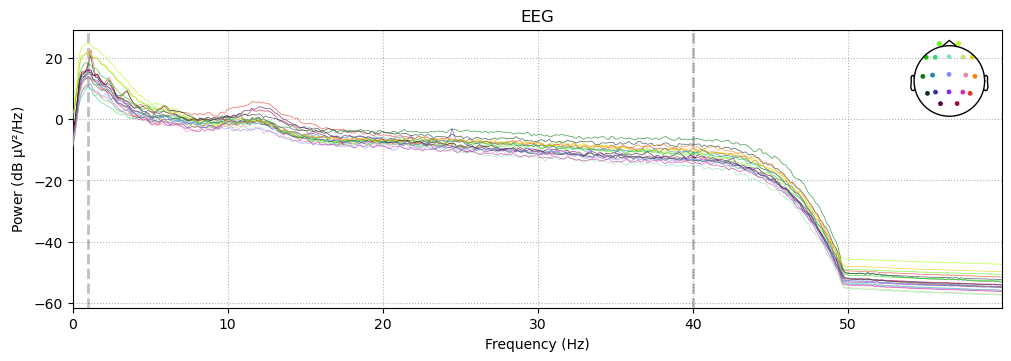

In [6]:
# Step 3: Filtering
# Extract filtering parameters from the configuration
filter_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'FilterStep')

# Use the FilterStep from the pipeline
from scr.steps.filter import FilterStep

# Create and apply the filter step
logger.info(f"Applying filtering using FilterStep")
filter_step = FilterStep(params=filter_config['params'])
raw = filter_step.run(raw)

# Plot power spectral density after filtering
fig, ax = plt.subplots(figsize=(10, 6))
raw.compute_psd(fmax=filter_config['params']['h_freq']*1.5, picks='eeg').plot(show=True)
ax.set_title('Power Spectral Density after Filtering')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB)')
plt.show()

# Plot filtered data
raw.plot(duration=10, n_channels=20, title='Filtered EEG data')

## Advanced Spectral Analysis

Let's use the spectral analysis utilities to visualize the data in different ways.

2025-04-14 16:17:19,622 - gonogo_minimal_preprocessing - INFO - Plotting standard PSD
2025-04-14 16:17:19,623 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-14 16:17:19,836 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)


Plotting power spectral density (dB=True).


d:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
d:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


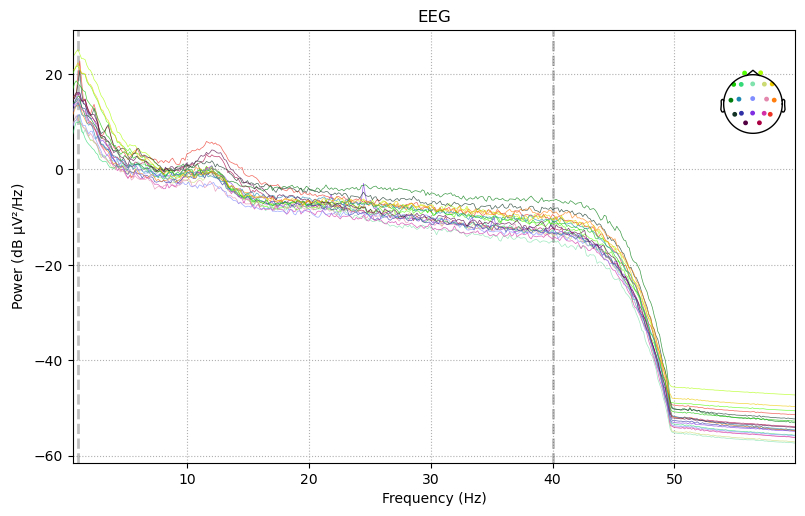

2025-04-14 16:17:20,135 - gonogo_minimal_preprocessing - INFO - Plotting average PSD
2025-04-14 16:17:20,136 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-14 16:17:20,363 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)


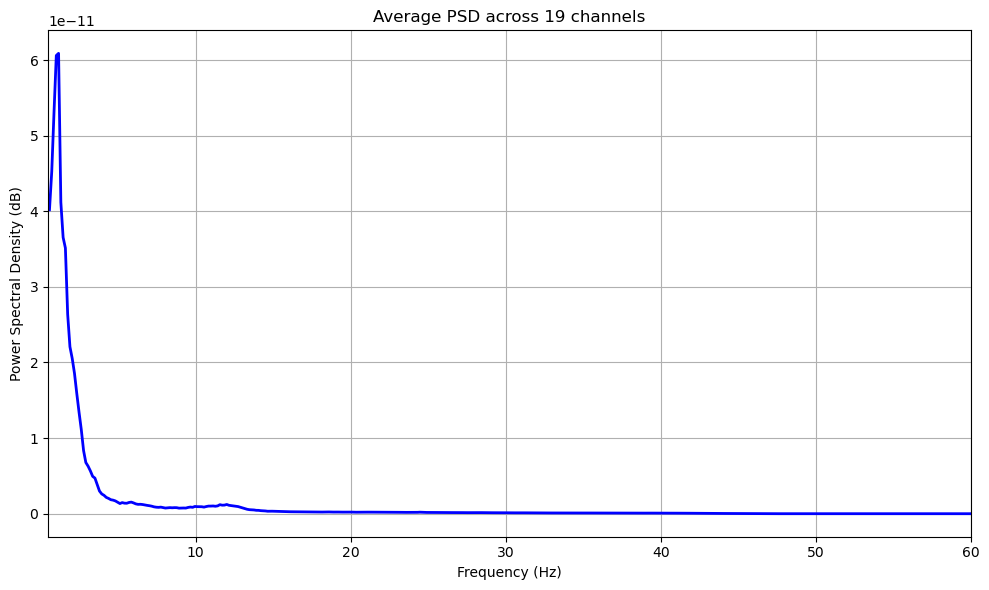

2025-04-14 16:17:20,534 - gonogo_minimal_preprocessing - INFO - Plotting PSD by frequency bands
2025-04-14 16:17:20,535 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-04-14 16:17:20,755 - root - INFO - PSD shape: (19, 304), Freqs shape: (304,)


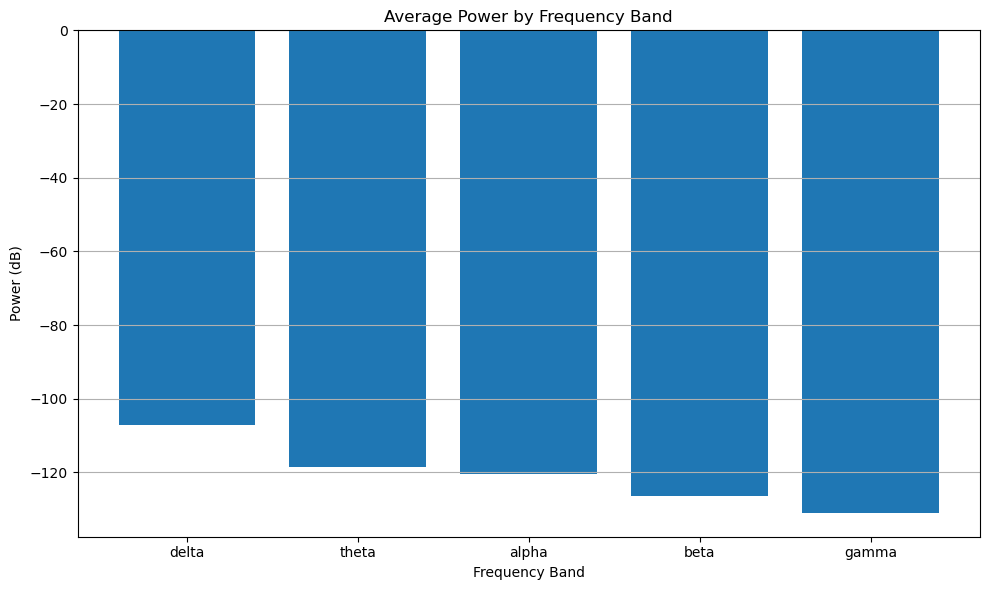

In [7]:
# Example of using the spectral analysis utilities
from scr.utils.spectral import compute_and_plot_psd

# Plot standard PSD
logger.info("Plotting standard PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='standard')
except Exception as e:
    logger.error(f"Error plotting standard PSD: {str(e)}")

# Plot average PSD across channels
logger.info("Plotting average PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='average',
                        plot_kwargs={'color': 'blue', 'linewidth': 2})
except Exception as e:
    logger.error(f"Error plotting average PSD: {str(e)}")

# Plot PSD by frequency bands
logger.info("Plotting PSD by frequency bands")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=45,
                        picks='eeg',
                        plot_type='bands',
                        plot_kwargs={'bands': {
                            'delta': (1, 4),
                            'theta': (4, 8),
                            'alpha': (8, 13),
                            'beta': (13, 30),
                            'gamma': (30, 45)
                        }})
except Exception as e:
    logger.error(f"Error plotting PSD by frequency bands: {str(e)}")

## Step 4: Epoching

Epoching segments the continuous data into time windows around stimulus events. For Go/No-Go tasks, we create epochs for:
- `go` events (event ID: 1): Stimuli requiring a response
- `nogo` events (event ID: 2): Stimuli requiring response inhibition
- `response` events (event ID: 3): Responses to stimuli

In [8]:

# Step 4: Epoching
# Extract epoching parameters from the configuration
epoch_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'EpochingStep')

# Make sure required parameters are set
if 'params' not in epoch_config:
    epoch_config['params'] = {}

# Set critical parameters for the Go/No-Go task
epoch_config['params']['task_type'] = 'gng'  # Ensure task type is explicitly set
epoch_config['params']['stim_channel'] = 'Trigger'  # Make sure stim channel is set

# Configure the event visualization
epoch_config['params']['visualize_events'] = True  # Enable event visualization
epoch_config['params']['plot_params'] = {
    # Event visualization parameters
    'duration': 15.0,          # Show 15 seconds of data for better visibility
    'tstart': 0.0,             # Start at beginning of recording
    'interactive': True,       # Show plots interactively in notebook
    'save_plots': True,        # Save figures to disk
    'save_dir': os.path.join(processed_dir, 'figures/events'),

    # Standard epoching visualization parameters (for auto_plot)
    'plot_type': 'average',
    'event_names': ['go', 'nogo'],
    'channels': ['Fz', 'Cz', 'Pz'],
    'time_window': [-0.2, 0.8]
}

# Log important parameters for reference
tmin = epoch_config['params']['epoch_params']['tmin']
tmax = epoch_config['params']['epoch_params']['tmax']
trigger_ids = epoch_config['params']['trigger_ids']
stim_channel = epoch_config['params']['stim_channel']
baseline = epoch_config['params']['epoch_params']['baseline']

print("\nEvent IDs for epoching:")
for event_name, event_id_val in trigger_ids.items():
    print(f"- {event_name}: {event_id_val}")

# Create and run the epoching step
from scr.steps.epoching import EpochingStep
logger.info(f"Creating epochs from {tmin}s to {tmax}s around events with task_type={epoch_config['params']['task_type']}")
epoch_step = EpochingStep(params=epoch_config['params'])

# Run the epoching step (will generate event visualizations automatically)
try:
    epochs = epoch_step.run(raw)

    # Display information about the epochs
    print("\nEpochs information:")
    print(epochs)


    # Generate additional visualizations to compare Go vs NoGo
    # This will create and save the comparative plots
    comparison_plots = epoch_step.generate_plots(
        epochs,
        plot_params={
            'plot_type': 'compare',
            'event_names': ['correct_go', 'correct_nogo'],
            'channels': ['Fz', 'Cz', 'Pz'],
            'title': 'Go vs NoGo Comparison',
            'save_plots': True, 
            'save_dir': os.path.join(processed_dir, 'figures/comparisons')
        }
    )
    
    # Show topographical maps at key time points (N2: ~250ms, P3: ~400ms)
    topo_plots = epoch_step.generate_plots(
        epochs,
        plot_params={
            'plot_type': 'topo',
            'event_names': ['correct_nogo'],  # Focus on NoGo condition which shows stronger N2/P3
            'time_window': [0, 0.5],
            'save_plots': True,
            'save_dir': os.path.join(processed_dir, 'figures/topos')
        }
    )
except Exception as e:
    logger.error(f"Error in epoching step: {str(e)}")
    


2025-04-14 16:17:29,050 - gonogo_minimal_preprocessing - INFO - Creating epochs from -0.2s to 1.0s around events with task_type=gng
2025-04-14 16:17:29,051 - root - INFO - [EpochingStep.__init__] Initialized with params: {'task_type': 'gng', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'tmin': -0.2, 'tmax': 1.0, 'baseline': [None, 0], 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_params': {'duration': 15.0, 'tstart': 0.0, 'interactive': True, 'save_plots': True, 'save_dir': 'D:/Yann/neurotheque_resources/data/processed\\figures/events', 'plot_type': 'average', 'event_names': ['go', 'nogo'], 'channels': ['Fz', 'Cz', 'Pz'], 'time_window': [-0.2, 0.8]}}
2025-04-14 16:17:29,052 - root - INFO - [EpochingStep.run] Running with params: {'task_type': 'gng', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'tmin': -0.2, 'tmax': 1.0, 'baseline': [None, 0], 'preload': T


Event IDs for epoching:
- go: 1
- nogo: 2
- response: 3
Trigger channel Trigger has a non-zero initial value of 7 (consider using initial_event=True to detect this event)
801 events found on stim channel Trigger
Event IDs: [1 2 3 4 8]


2025-04-14 16:17:29,069 - root - INFO - [EpochingStep] Found 801 total events
2025-04-14 16:17:29,070 - root - INFO - Event IDs found: [1 2 3 4 8]
2025-04-14 16:17:29,088 - root - INFO - [EpochingStep] Showing 6 events in time window [0.0, 10.0]s
2025-04-14 16:17:29,089 - root - INFO -   Event 0: ID=8, time=0.050s, sample=81043
2025-04-14 16:17:29,090 - root - INFO -   Event 1: ID=2, time=2.027s, sample=81636
2025-04-14 16:17:29,091 - root - INFO -   Event 2: ID=3, time=5.993s, sample=82826
2025-04-14 16:17:29,091 - root - INFO -   Event 3: ID=1, time=6.513s, sample=82982
2025-04-14 16:17:29,092 - root - INFO -   Event 4: ID=3, time=8.207s, sample=83490
2025-04-14 16:17:29,163 - root - INFO - [EpochingStep] Simple event visualization created
2025-04-14 16:17:29,613 - root - INFO - [EpochingStep] Saved figure to D:\Yann\neurotheque_resources\data\processed\figures\events\sub-unknown_ses-001_plot-1.png
2025-04-14 16:17:29,614 - root - INFO - [EpochingStep] Event counts: 300 go, 100 nogo,

Not setting metadata
396 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 396 events and 361 original time points ...
0 bad epochs dropped


2025-04-14 16:17:29,735 - root - INFO - [EpochingStep] Created 396 epochs for Go/No-Go task with 2 conditions
2025-04-14 16:17:29,735 - root - INFO - [EpochingStep] Available conditions: ['correct_go', 'correct_nogo']


Adding metadata with 0 columns

Epochs information:
<Epochs | 396 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~21.8 MiB, data loaded, with metadata,
 'correct_go': 300
 'correct_nogo': 96>


2025-04-14 16:17:30,357 - root - INFO - [EpochingStep] Saved figure to D:\Yann\neurotheque_resources\data\processed\figures\comparisons\sub-unknown_ses-001_plot-1.png
2025-04-14 16:17:30,393 - root - ERROR - Error in topo plot: Evoked.plot_topomap() got an unexpected keyword argument 'title'


In [9]:
# Define output file path and save epochs

# Get save checkpoint step configuration from pipeline config
save_checkpoint_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'SaveCheckpoint')

# Import the SaveCheckpoint class from the pipeline steps
from scr.steps.save_checkpoint import SaveCheckpoint

# Create paths object from config if not already available
from scr.steps.project_paths import ProjectPaths
paths = ProjectPaths(config)

# Prepare parameters for SaveCheckpoint
save_params = save_checkpoint_config.get('params', {}).copy()

# Add required parameters
save_params.update({
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "task_id": "gng",
    "run_id": config.get('default_run', '01'),
    "checkpoint_key": "epoched",  # Customize the checkpoint name
    "paths": paths,
    "overwrite": True
})

# Create and run the SaveCheckpoint step
save_step = SaveCheckpoint(params=save_params)
save_step.run(epochs)

# Get the path for informational message
checkpoint_path = paths.get_checkpoint_path(
    subject_id=save_params["subject_id"],
    session_id=save_params["session_id"],
    task_id=save_params["task_id"],
    run_id=save_params["run_id"],
    checkpoint_name=save_params["checkpoint_key"]
)

print(f"\nPreprocessed epochs saved as checkpoint: {checkpoint_path}")



2025-04-14 16:17:33,148 - root - INFO - Saving checkpoint to: D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


Overwriting existing file.
Overwriting existing file.


d:\Yann\neurotheque_resources\scr\steps\save_checkpoint.py:26: RuntimeWarning: This filename (D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data.save(ckpt_path, overwrite=True)



Preprocessed epochs saved as checkpoint: D:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


Channels marked as bad:
[np.str_('Pz')]


## Visualizing Epochs

Now that we have created epochs, let's visualize them in different ways.

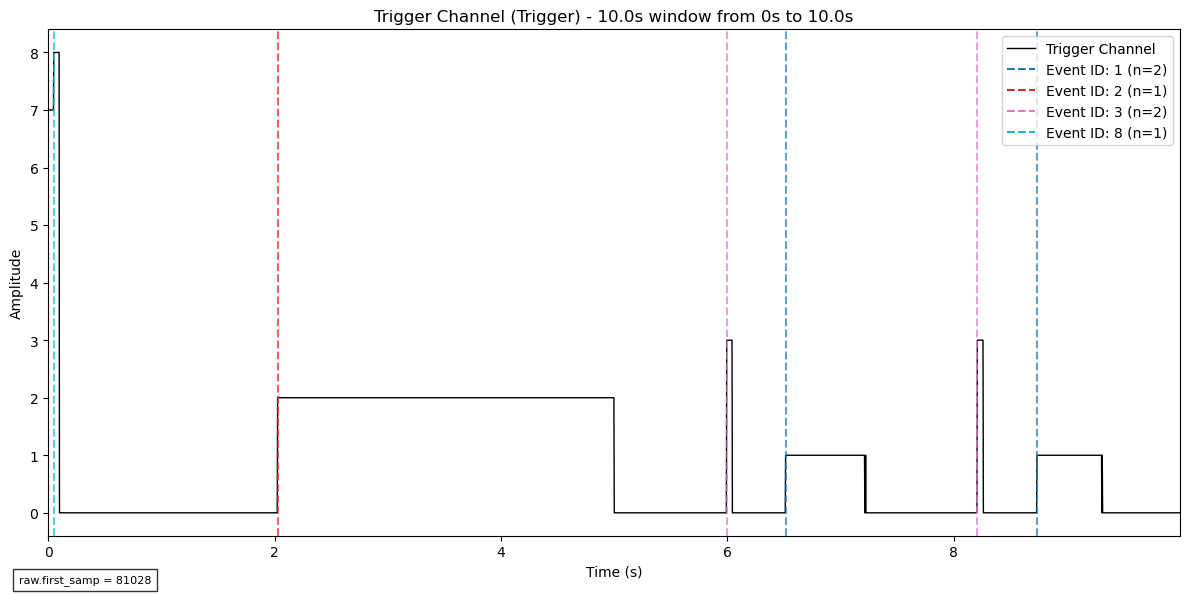

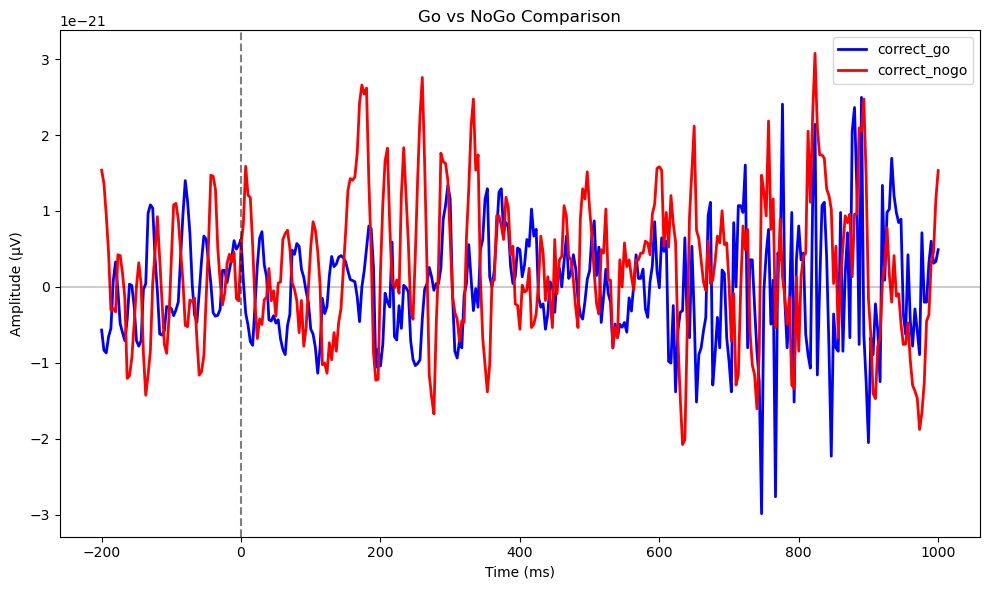

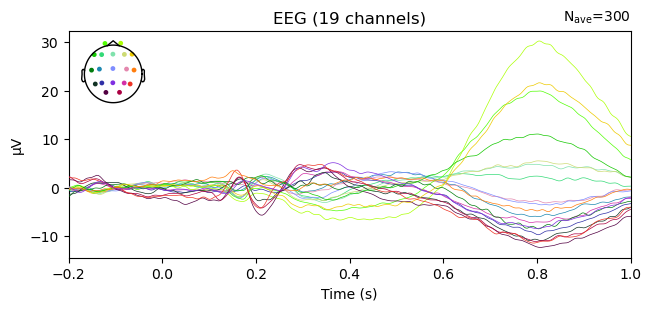

<Figure size 640x480 with 0 Axes>

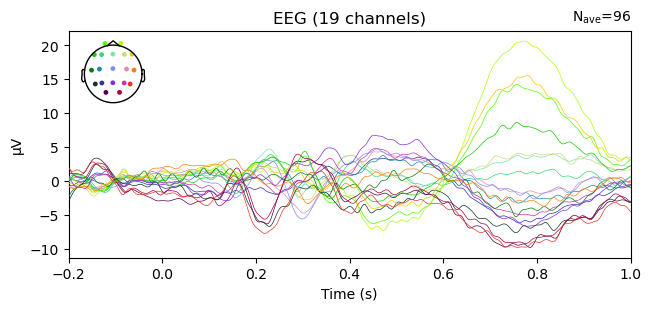

2025-04-14 16:37:57,992 - root - ERROR - Error in compare plot: 'Event name "go" could not be found. The following events are present in the data: correct_go, correct_nogo The epochs.metadata Pandas query did not yield any results: name \'go\' is not defined'


Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated


2025-04-14 16:37:58,055 - root - ERROR - Error in image plot: 'bool' object is not callable


Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated


2025-04-14 16:37:58,110 - root - ERROR - Error in image plot: 'bool' object is not callable
2025-04-14 16:37:58,126 - root - ERROR - Error in difference plot: 'Event name "nogo" could not be found. The following events are present in the data: correct_go, correct_nogo The epochs.metadata Pandas query did not yield any results: name \'nogo\' is not defined'


In [10]:
# Use the plot_epochs method to create various visualizations
try:
    # Plot 1: Average ERPs for each condition
    epoch_step.plot_epochs(epochs, plot_type='average')
    
    # Plot 2: Compare Go vs NoGo conditions
    epoch_step.plot_epochs(epochs, 
                        plot_type='compare',
                        event_names=['go', 'nogo'])
                        
    # Plot 3: Selected channels
    selected_channels = ['Fz', 'Cz', 'Pz']
    epoch_step.plot_epochs(epochs, 
                        plot_type='image',
                        channels=selected_channels, 
                        combine=True,
                        title='Epochs image plot')
                        
    # Plot 4: Difference wave (NoGo - Go)
    epoch_step.plot_epochs(epochs,
                        plot_type='difference',
                        event_names=['nogo', 'go'],
                        channels='eeg',
                        title='NoGo - Go Difference Wave')
except Exception as e:
    logger.error(f"Error in plotting epochs: {str(e)}")

## Comparing Go vs. No-Go Responses

One of the key analyses in Go/No-Go tasks is comparing the ERPs for Go and NoGo conditions. Let's create a visualization to compare these responses.

In [11]:
# Calculate ERPs for Go and NoGo conditions
try:
    go_erp = epochs['go'].average()
    nogo_erp = epochs['nogo'].average()

    # Create a comparison plot for key midline electrodes (Fz, Cz, Pz)
    channels_to_plot = ['Fz', 'Cz', 'Pz']

    fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(10, 12))
    times = epochs.times * 1000  # Convert to milliseconds

    for i, channel in enumerate(channels_to_plot):
        axes[i].plot(times, go_erp.data[go_erp.ch_names.index(channel)], 'b-', linewidth=2, label='Go')
        axes[i].plot(times, nogo_erp.data[nogo_erp.ch_names.index(channel)], 'r-', linewidth=2, label='NoGo')
        axes[i].axvline(x=0, color='k', linestyle='--')  # Mark stimulus onset
        axes[i].axhline(y=0, color='k', linestyle=':')
        axes[i].set_xlim([tmin*1000, tmax*1000])
        axes[i].set_title(f'Channel {channel}', fontsize=14)
        axes[i].set_ylabel('Amplitude (μV)')
        axes[i].legend(loc='best')
        
        # Highlight potential components
        if channel == 'Fz' or channel == 'Cz':
            axes[i].axvspan(200, 350, alpha=0.2, color='g', label='N2 range')
        if channel == 'Cz' or channel == 'Pz':
            axes[i].axvspan(350, 500, alpha=0.2, color='y', label='P3 range')

    axes[-1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.suptitle('Comparison of Go vs. NoGo ERPs', fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()
except Exception as e:
    logger.error(f"Error creating comparison plots: {str(e)}")

2025-04-14 16:38:17,271 - gonogo_minimal_preprocessing - ERROR - Error creating comparison plots: 'Event name "go" could not be found. The following events are present in the data: correct_go, correct_nogo The epochs.metadata Pandas query did not yield any results: name \'go\' is not defined'


## Topographic Maps

Topographic maps help visualize the distribution of ERP components across the scalp.

In [12]:
# Create topographic maps for key time points
try:
    n2_time = 0.250  # 250 ms
    p3_time = 0.400  # 400 ms

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # N2 Go
    go_erp.plot_topomap(times=n2_time, axes=axes[0, 0], show=False, colorbar=True)
    axes[0, 0].set_title('Go - N2 (250 ms)')

    # N2 NoGo
    nogo_erp.plot_topomap(times=n2_time, axes=axes[0, 1], show=False, colorbar=True)
    axes[0, 1].set_title('NoGo - N2 (250 ms)')

    # P3 Go
    go_erp.plot_topomap(times=p3_time, axes=axes[1, 0], show=False, colorbar=True)
    axes[1, 0].set_title('Go - P3 (400 ms)')

    # P3 NoGo
    nogo_erp.plot_topomap(times=p3_time, axes=axes[1, 1], show=False, colorbar=True)
    axes[1, 1].set_title('NoGo - P3 (400 ms)')

    plt.tight_layout()
    plt.suptitle('Topographic Distribution of ERP Components', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
except Exception as e:
    logger.error(f"Error creating topographic maps: {str(e)}")

2025-04-14 16:38:20,365 - gonogo_minimal_preprocessing - ERROR - Error creating topographic maps: name 'go_erp' is not defined


## Saving the Processed Data

Finally, we'll save the preprocessed epochs for future analysis.

In [14]:


# Define output file path using EXACT format required by the intermediate pipeline
try:
    # Get parameters from config
    sub_id = config.get('default_subject', '01')
    ses_id = config.get('default_session', '001')
    run_id = config.get('default_run', '01')
    
    # Create output directory
    output_dir = os.path.join(
        config['directory']['root'],
        config['directory']['processed_dir'],
        f"sub-{sub_id}",
        f"ses-{ses_id}"
    )
    os.makedirs(output_dir, exist_ok=True)
    
    # Create output file path with EXACT format
    output_file = os.path.join(
        output_dir,
        f"sub-{sub_id}_ses-{ses_id}_task-gng_run-{run_id}_preprocessed-epoched.fif"
    )
    
    # Save epochs with the exact format
    logger.info(f"Saving epochs with the EXACT required format to: {output_file}")
    epochs.save(output_file, overwrite=True)
    print(f"\nPreprocessed epochs saved with exact required format to: {output_file}")
    
except Exception as e:
    logger.error(f"Error saving preprocessed data: {str(e)}")
    import traceback
    logger.error(traceback.format_exc())



2025-04-14 16:58:46,156 - gonogo_minimal_preprocessing - INFO - Saving epochs with the EXACT required format to: D:/Yann/neurotheque_resources/data/processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif


Overwriting existing file.
Overwriting existing file.


C:\Users\s\AppData\Local\Temp\ipykernel_6048\2738999900.py:25: RuntimeWarning: This filename (D:/Yann/neurotheque_resources/data/processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(output_file, overwrite=True)



Preprocessed epochs saved with exact required format to: D:/Yann/neurotheque_resources/data/processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_preprocessed-epoched.fif


## Conclusion

This notebook demonstrated the minimal preprocessing pipeline for Go/No-Go task data. We've covered:

1. **Loading the raw data** from FIFF files
2. **Handling ECG and non-EEG channels** explicitly to avoid issues
3. **Preparing channels** with proper referencing
4. **Filtering** with bandpass (1-40 Hz) and notch filters (50/60 Hz)
5. **Epoching** the data around Go and NoGo events with the correct task_type
6. **Visualizing** the ERPs and their topographic distributions
7. **Saving** the preprocessed data for future analysis

The minimal pipeline provides the essential preprocessing steps for analyzing Go/No-Go task data without more complex operations like ICA or advanced artifact rejection. For more complex preprocessing needs, consider using the intermediate or advanced pipeline configurations.

### Key ERP Components in Go/No-Go Tasks

- **N2 component** (200-350 ms): Associated with conflict monitoring and inhibitory processing. Typically enhanced (more negative) for NoGo compared to Go trials, especially at frontocentral electrodes (Fz, Cz).
- **P3 component** (350-500 ms): Associated with response inhibition (NoGo-P3) and response execution (Go-P3). The NoGo-P3 typically has a more anterior distribution (Cz), while the Go-P3 has a more posterior distribution (Pz).

These components are key neural markers of response inhibition processes in the Go/No-Go task.